In [9]:
import os
import shutil
import random
from tqdm import tqdm

# plantvillage-tomatoes klasörü notebook ile aynı seviyede (../ ile çıkıyoruz)
source_dir = "../plantvillage-tomatoes"
base_dir = "../data"
splits = ["train", "val", "test"]
split_ratios = [0.7, 0.2, 0.1]

# train, val, test klasörlerini oluştur
for split in splits:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)

# Her sınıf klasörünü dolaş ve görselleri bölüştür
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        random.shuffle(images)

        n_total = len(images)
        n_train = int(n_total * split_ratios[0])
        n_val = int(n_total * split_ratios[1])
        n_test = n_total - n_train - n_val

        split_data = {
            "train": images[:n_train],
            "val": images[n_train:n_train+n_val],
            "test": images[n_train+n_val:]
        }

        for split in splits:
            split_dir = os.path.join(base_dir, split, class_name)
            os.makedirs(split_dir, exist_ok=True)

            for img_name in tqdm(split_data[split], desc=f"{class_name} - {split}"):
                src = os.path.join(class_path, img_name)
                dst = os.path.join(split_dir, img_name)
                shutil.copyfile(src, dst)


Tomato_Septoria_leaf_spot - test: 100%|██████████| 178/178 [00:01<00:00, 152.79it/s]
Tomato_Spider_mites_Two_spotted_spider_mite - train: 100%|██████████| 1173/1173 [00:08<00:00, 141.85it/s]
Tomato_Spider_mites_Two_spotted_spider_mite - val: 100%|██████████| 335/335 [00:02<00:00, 131.43it/s]
Tomato_Spider_mites_Two_spotted_spider_mite - test: 100%|██████████| 168/168 [00:01<00:00, 139.54it/s]
Tomato__Tomato_YellowLeaf__Curl_Virus - test: 100%|██████████| 322/322 [00:02<00:00, 140.09it/s]


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Resim boyutu
img_size = (224, 224)
batch_size = 32

# Eğitim verisi için augmentasyon
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

In [11]:
# Doğrulama ve test verisi sadece ölçeklenecek
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Klasör yolları (notebook konumuna göre)
train_dir = "../data/train"
val_dir = "../data/val"
test_dir = "../data/test"

In [12]:
# Verileri yükle
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 14577 images belonging to 10 classes.
Found 5782 images belonging to 10 classes.
Found 3058 images belonging to 10 classes.


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

# Sınıf sayısını otomatik al
num_classes = train_generator.num_classes

# Modeli tanımla
model = Sequential([
    Input(shape=(224, 224, 3)),Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Derleme
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model özeti
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,250 (42.61 MB)

 Trainable params: 11,170,250 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Modeli eğitiyoruz
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3508 - loss: 1.8853      

C:\Users\Monster\anaconda3\envs\handwriting-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


456/456 ━━━━━━━━━━━━━━━━━━━━ 539s 1s/step - accuracy: 0.3511 - loss: 1.8846 - val_accuracy: 0.6276 - val_loss: 1.1868
Epoch 2/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 353s 773ms/step - accuracy: 0.6068 - loss: 1.1898 - val_accuracy: 0.6667 - val_loss: 1.0846
Epoch 3/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 355s 779ms/step - accuracy: 0.6660 - loss: 0.9917 - val_accuracy: 0.7107 - val_loss: 0.8955
Epoch 4/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 378s 829ms/step - accuracy: 0.7035 - loss: 0.8631 - val_accuracy: 0.6887 - val_loss: 1.0150
Epoch 5/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 345s 755ms/step - accuracy: 0.7329 - loss: 0.7771 - val_accuracy: 0.7245 - val_loss: 0.8924
Epoch 6/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 343s 751ms/step - accuracy: 0.7500 - loss: 0.7189 - val_accuracy: 0.7817 - val_loss: 0.6797
Epoch 7/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 345s 756ms/step - accuracy: 0.7846 - loss: 0.6305 - val_accuracy: 0.7876 - val_loss: 0.6725
Epoch 8/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 396s 869ms/step - accuracy: 0.7871 - loss: 0.6102 

📁 Görsel yolu: ../data/test\Tomato_Leaf_Mold\822c1a03-77c7-4640-bf3b-055542fda0bb___Crnl_L.Mold 6950.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


C:\Users\Monster\anaconda3\envs\handwriting-env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


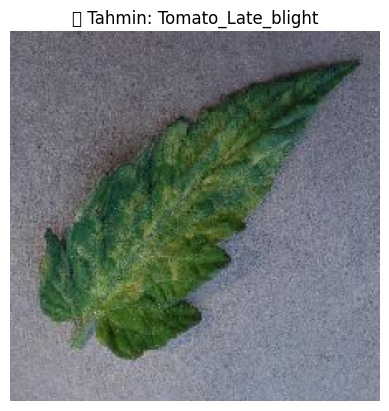

In [13]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Rastgele görsel seç
random_class = random.choice(class_names)
random_class_path = os.path.join(test_root, random_class)
random_image = random.choice(os.listdir(random_class_path))
img_path = os.path.join(random_class_path, random_image)

print(f"📁 Görsel yolu: {img_path}")

# Görseli yükle ve ön işleme yap
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Tahmin
prediction = model.predict(img_array)
predicted_class = class_names[np.argmax(prediction)]

# Görsel ve sonuç
plt.imshow(img)
plt.axis('off')
plt.title(f"🔍 Tahmin: {predicted_class}")
plt.show()